# See how to change the underlying coordinates_AIS file to fix issues on land

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cmocean
import cartopy.crs as ccrs

Load files

In [6]:
folder='/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/bathymetry/'

global_grid = xr.open_dataset(f'{folder}domcfg_eORCA025_v3.nc').isel(time_counter=0)
coord_AIS   = xr.open_dataset(f'{folder}coordinates_AIS.nc').isel(time_counter=0)
domcfg_old  = xr.open_dataset(f'{folder}domain_cfg-old.nc').isel(time_counter=0)
domcfg_new  = xr.open_dataset(f'{folder}domain_cfg-20231025.nc').isel(time_counter=0)

Variables with issues in coordinates_AIS: nav_lat, e2f, e2v, e2u, e2t, e1f, e1v, e1u, e1t, gphif, gphiv, gphiu, gphit
--> domcfg_old contains all of the issue areas filled, so could try to just fill the problem areas with the values from it.

In [9]:
domcfg_old

<xarray.Dataset>
Dimensions:       (y: 439, x: 1440, nav_lev: 121)
Coordinates:
  * nav_lev       (nav_lev) float32 0.4921 1.526 2.638 ... 5.698e+03 5.902e+03
    time_counter  float32 0.0
Dimensions without coordinates: y, x
Data variables: (12/41)
    nav_lon       (y, x) float32 ...
    nav_lat       (y, x) float32 ...
    jpiglo        int32 ...
    jpjglo        int32 ...
    jpkglo        int32 ...
    jperio        int32 ...
    ...            ...
    e3uw_0        (nav_lev, y, x) float64 ...
    e3vw_0        (nav_lev, y, x) float64 ...
    bottom_level  (y, x) int32 ...
    top_level     (y, x) int32 ...
    isf_draft     (y, x) float64 ...
    bathy_metry   (y, x) float64 ...
Attributes:
    file_name:  domain_cfg.nc
    TimeStamp:  24/11/2022 14:28:20 +0100

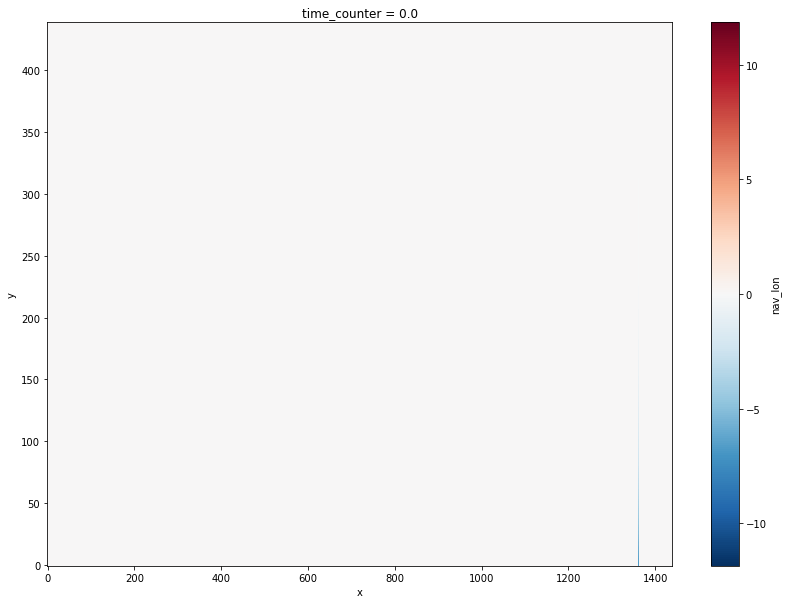

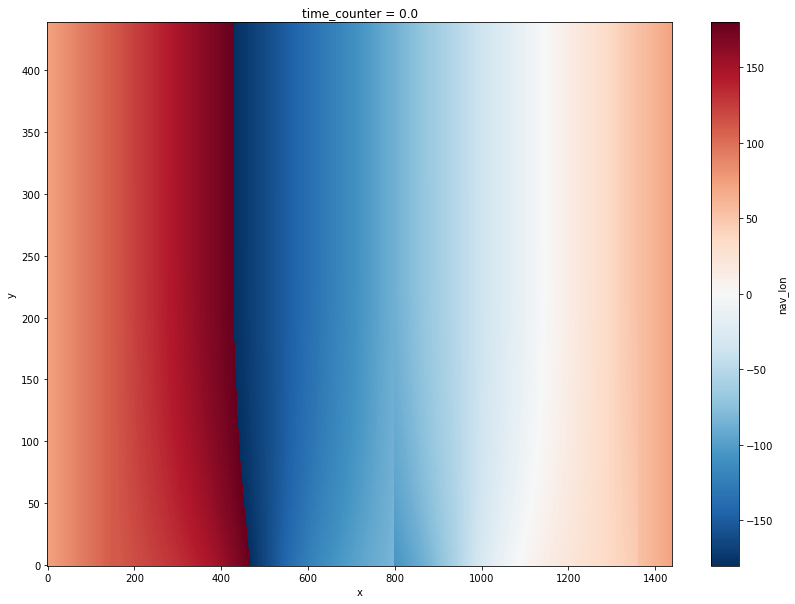

In [35]:
(domcfg_old.nav_lon - domcfg_new.nav_lon).plot(figsize=(14,10))
(domcfg_new.nav_lon).plot(figsize=(14,10))

# For now, instead of fixing coordinates_AIS.nc let's just manually fix the domain_cfg file

Variables to fix: bottom_level (both in the Antarctic and the Strait of Magellan and coastal fjords

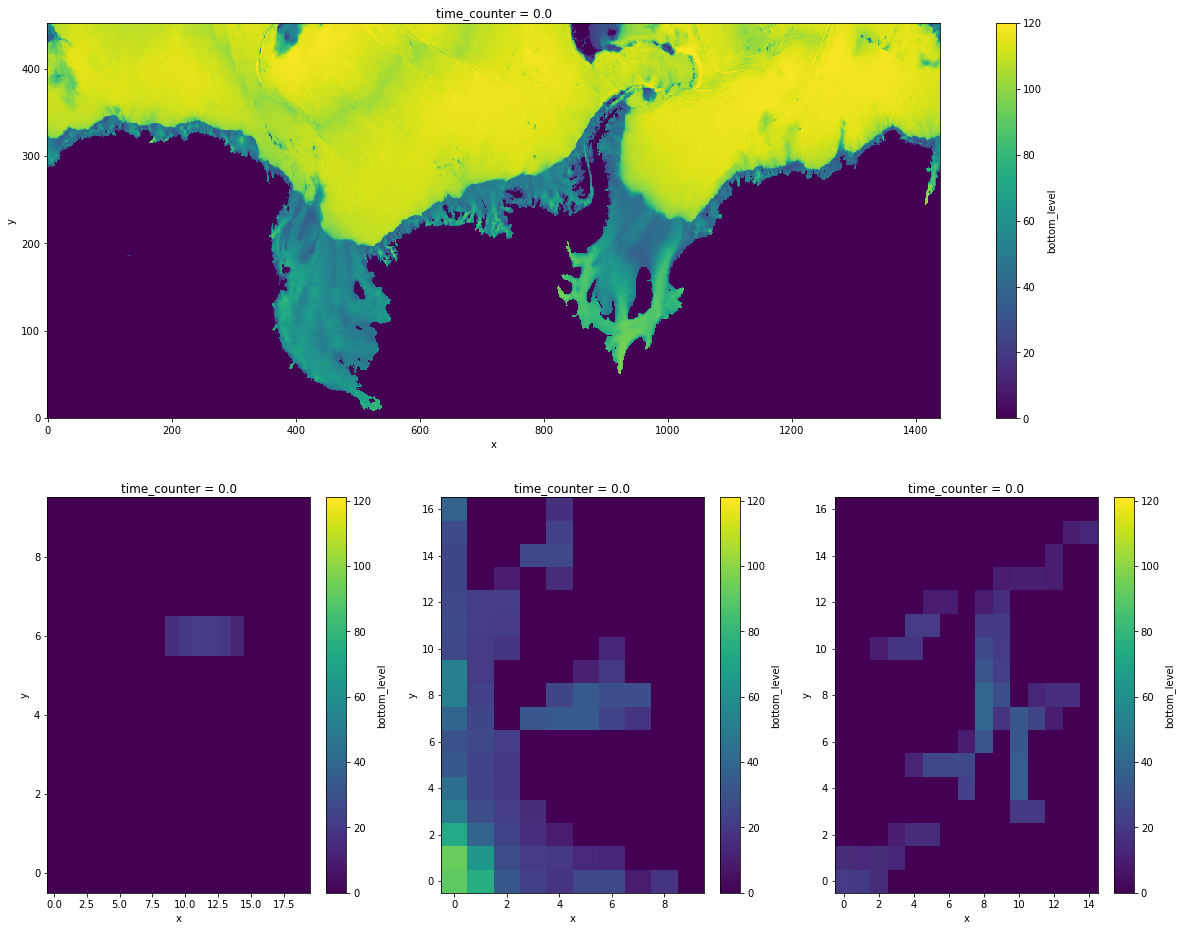

In [64]:
fig = plt.figure(figsize=(20,13))
gs  = fig.add_gridspec(2,3)
ax1 = fig.add_subplot(gs[0,:]); ax2 = fig.add_subplot(gs[1,0]);
ax3 = fig.add_subplot(gs[1,1]); ax4 = fig.add_subplot(gs[1,2]);

domcfg_new.bottom_level.plot(ax=ax1)
domcfg_new.bottom_level.isel(x=slice(120,140), y=slice(180,190)).plot(ax=ax2, vmin=0, vmax=121)
domcfg_new.bottom_level.isel(x=slice(845,855), y=slice(435,-1)).plot(ax=ax3, vmin=0, vmax=121)
domcfg_new.bottom_level.isel(x=slice(857,872), y=slice(422,439)).plot(ax=ax4, vmin=0, vmax=121)

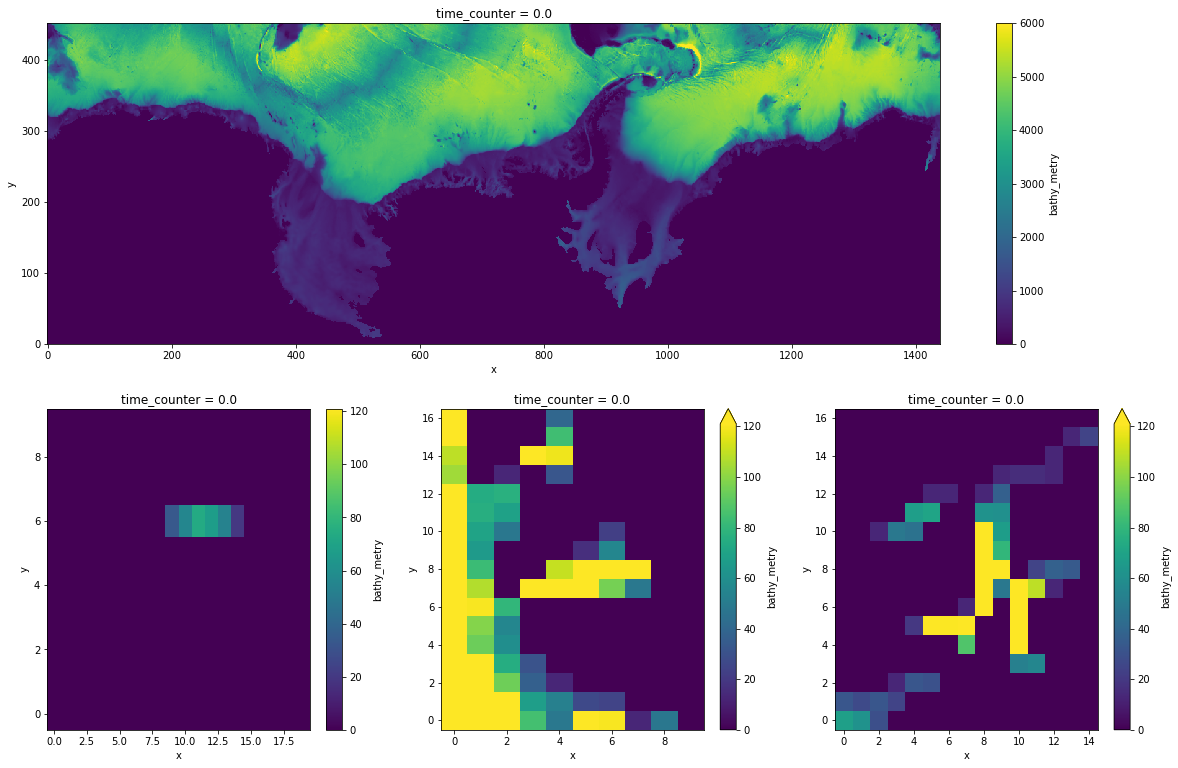

In [81]:
fig = plt.figure(figsize=(20,13))
gs  = fig.add_gridspec(2,3)
ax1 = fig.add_subplot(gs[0,:]); ax2 = fig.add_subplot(gs[1,0]);
ax3 = fig.add_subplot(gs[1,1]); ax4 = fig.add_subplot(gs[1,2]);

domcfg_new.bathy_metry.plot(ax=ax1)
domcfg_new.bathy_metry.isel(x=slice(120,140), y=slice(180,190)).plot(ax=ax2, vmin=0, vmax=121)
domcfg_new.bathy_metry.isel(x=slice(845,855), y=slice(435,-1)).plot(ax=ax3, vmin=0, vmax=121)
domcfg_new.bathy_metry.isel(x=slice(857,872), y=slice(422,439)).plot(ax=ax4, vmin=0, vmax=121)

So, need to fill x=128:135, y=186 with zeros to remove lakes in Antarctica

Need to fill x=848:850, y=447:453 and x=848:853, y=441:446 with zeros to close the fjords.

And need to fill x=856:867, y=426:438 and x=863:872, y=424:431, with zeros to close the strait of magellan

In [103]:
domcfg_filled = domcfg_new.copy()

In [104]:
bottom_array = domcfg_filled.bottom_level.values
bathy_array  = domcfg_filled.bathy_metry.values

bottom_array[186, slice(128,135)] = 0
bottom_array[slice(447,453), slice(848,850)] = 0
bottom_array[slice(441,446), slice(848,853)] = 0
bottom_array[slice(426,438), slice(856,870)] = 0
bottom_array[slice(424,431), slice(863,872)] = 0

bathy_array[186, slice(128,135)] = 0
bathy_array[slice(447,453), slice(848,850)] = 0
bathy_array[slice(441,446), slice(848,853)] = 0
bathy_array[slice(426,438), slice(856,870)] = 0
bathy_array[slice(424,431), slice(863,872)] = 0

In [105]:
domcfg_filled['bottom_level'] = (('y', 'x'), bottom_array)
domcfg_filled['bathy_metry'] = (('y', 'x'), bathy_array.astype('float'))

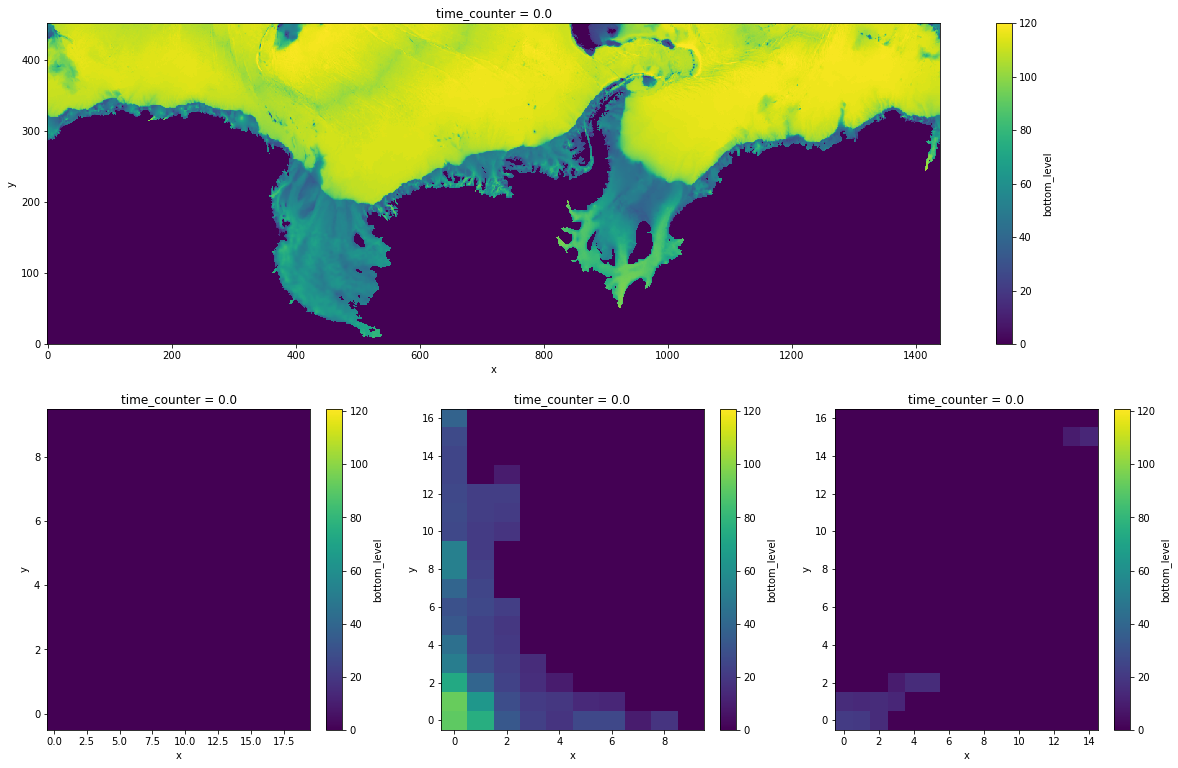

In [92]:
fig = plt.figure(figsize=(20,13))
gs  = fig.add_gridspec(2,3)
ax1 = fig.add_subplot(gs[0,:]); ax2 = fig.add_subplot(gs[1,0]);
ax3 = fig.add_subplot(gs[1,1]); ax4 = fig.add_subplot(gs[1,2]);

domcfg_filled.bottom_level.plot(ax=ax1)
domcfg_filled.bottom_level.isel(x=slice(120,140), y=slice(180,190)).plot(ax=ax2, vmin=0, vmax=121)
domcfg_filled.bottom_level.isel(x=slice(845,855), y=slice(435,-1)).plot(ax=ax3, vmin=0, vmax=121)
domcfg_filled.bottom_level.isel(x=slice(857,872), y=slice(422,439)).plot(ax=ax4, vmin=0, vmax=121)

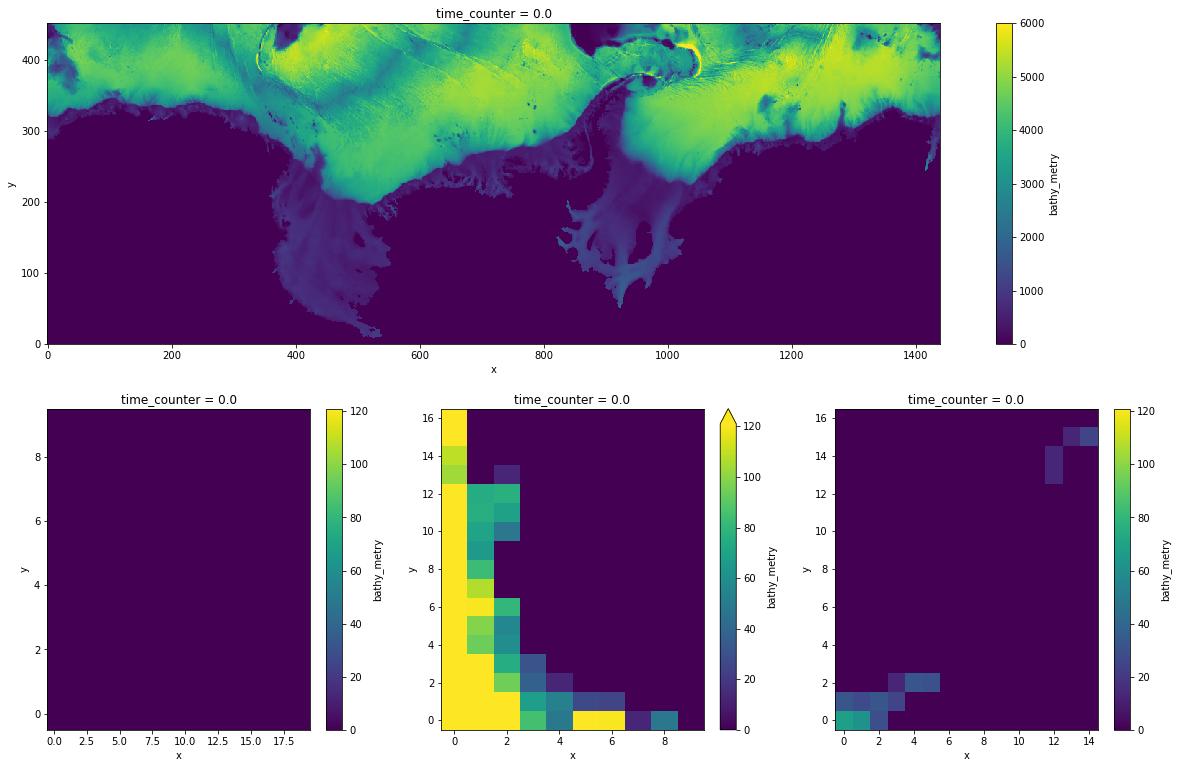

In [89]:
fig = plt.figure(figsize=(20,13))
gs  = fig.add_gridspec(2,3)
ax1 = fig.add_subplot(gs[0,:]); ax2 = fig.add_subplot(gs[1,0]);
ax3 = fig.add_subplot(gs[1,1]); ax4 = fig.add_subplot(gs[1,2]);

domcfg_filled.bathy_metry.plot(ax=ax1)
domcfg_filled.bathy_metry.isel(x=slice(120,140), y=slice(180,190)).plot(ax=ax2, vmin=0, vmax=121)
domcfg_filled.bathy_metry.isel(x=slice(845,855), y=slice(435,-1)).plot(ax=ax3, vmin=0, vmax=121)
domcfg_filled.bathy_metry.isel(x=slice(857,872), y=slice(422,439)).plot(ax=ax4, vmin=0, vmax=121)

In [107]:
domcfg_filled.to_netcdf(f'{folder}domain_cfg-20231025-filledlakes.nc')